## Isolating weather Stations in wine areas

In [67]:
import pandas as pd
import os
import requests
import openpyxl
import matplotlib.pyplot as plt

from dotenv import load_dotenv

In [68]:
 # Load environment variables from .env file
load_dotenv()

# Get the API key
api_key = os.getenv('NOAA_CLIMATE_DATA')
token = api_key

In [69]:
# Load the Weather Data
file_path = 'Resources/weather_all_country_codes3.csv'
df = pd.read_csv(file_path)

# Pivot the Weather DataFrame
pivoted_df = df.pivot_table(index=['station', 'date'], columns='datatype', values='value').reset_index()

# Update the 'country' values
pivoted_df['country'] = pivoted_df['station'].str[:2]

# Load the Station Codes Data
column_names = ['station_id', 'latitude', 'longitude', 'elevation', 'location']
colspecs = [(0, 11), (12, 20), (21, 30), (31, 37), (38, None)]
file_path_txt = 'Resources/stationcodes.txt'
df_station_codes = pd.read_fwf(file_path_txt, colspecs=colspecs, header=None, names=column_names)

# Rename Columns for Merging
df_station_codes.rename(columns={'station_id': 'station'}, inplace=True)

# Clean Column Names
pivoted_df.columns = pivoted_df.columns.str.strip()
df_station_codes.columns = df_station_codes.columns.str.strip()

# Remove the 'GHCND:' prefix from the 'station' column in both DataFrames
pivoted_df['station'] = pivoted_df['station'].str.replace('GHCND:', '')
df_station_codes['station'] = df_station_codes['station'].str.replace('GHCND:', '')

# Merge the DataFrames
merged_df = pd.merge(pivoted_df, df_station_codes, on='station', how='left')

# Export the merged DataFrame to a CSV file
output_file_path = 'Resources/merged_weather_data.csv'
merged_df.to_csv(output_file_path, index=False)
print(f"Merged DataFrame exported to {output_file_path}")




Merged DataFrame exported to Resources/merged_weather_data.csv


In [70]:
# Function to get location data from the NCEI API
def get_location_data(station_id, token):
    base_url = "https://www.ncei.noaa.gov/access/services/search/v1/data"
    params = {
        "dataset": "global-summary-of-the-year",
        "stations": station_id,
        "startDate": "1995-01-01",
        "endDate": "2023-12-31",
        "includeStationLocation": "1"
    }
    headers = {"token": token}
    response = requests.get(base_url, params=params, headers=headers)
    try:
        response.raise_for_status()  # Raise an HTTPError for bad responses
        json_response = response.json()
        if isinstance(json_response, list) and json_response:
            data = json_response[0]
            return {
                "latitude": data.get("latitude"),
                "longitude": data.get("longitude"),
                "elevation": data.get("elevation"),
                "location": data.get("name")
            }
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred: {http_err}")  # HTTP error
    except requests.exceptions.RequestException as req_err:
        print(f"Request error occurred: {req_err}")  # Request error
    except ValueError as json_err:
        print(f"JSON decode error occurred: {json_err}")  # JSON decode error
        print(f"Response content: {response.content}")  # Print response content for debugging
    return None

# Function to update the DataFrame with location data
def update_station_data(row, token):
    station_id = row['station']
    location_data = get_location_data(station_id, token)
    if location_data:
        row['latitude'] = location_data['latitude']
        row['longitude'] = location_data['longitude']
        row['elevation'] = location_data['elevation']
        row['location'] = location_data['location']
    return row


# Update the stations without location data
stations_without_location = stations_without_location.apply(update_station_data, axis=1, token=token)

# Merge updated data back into the main DataFrame
merged_df.update(stations_without_location)

# Display the updated DataFrame
print("Updated DataFrame with new location data:")
print(merged_df.head())

# Check for stations that still have missing latitude and longitude values
stations_still_missing_location = merged_df[merged_df[['latitude', 'longitude']].isnull().any(axis=1)]
print("Stations still missing latitude and longitude:")
print(stations_still_missing_location[['station', 'latitude', 'longitude']])

HTTP error occurred: 503 Server Error: Service Unavailable for url: https://www.ncei.noaa.gov/access/services/search/v1/data?dataset=global-summary-of-the-year&stations=nan&startDate=1995-01-01&endDate=2023-12-31&includeStationLocation=1
Updated DataFrame with new location data:
       station                 date  DP10  DP1X  DT32   DX70   DX90  EMNT  \
0  AE000041196  2012-01-01T00:00:00   NaN   NaN   NaN  346.0  226.0   NaN   
1  AE000041196  2023-01-01T00:00:00   8.0   1.0   NaN    NaN    NaN   NaN   
2  AEM00041194  2004-01-01T00:00:00   4.0   0.0   NaN    NaN    NaN   NaN   
3  AEM00041194  2006-01-01T00:00:00   7.0   1.0   NaN    NaN    NaN   NaN   
4  AEM00041194  2010-01-01T00:00:00   5.0   1.0   NaN    NaN    NaN   NaN   

   EMXP   EMXT  ...  MNPN  MXPN  PRCP  TAVG  TMAX  country latitude  \
0   NaN  121.0  ...   NaN   NaN   NaN   NaN  96.0       GH   25.333   
1  1.06    NaN  ...   NaN   NaN  3.42   NaN   NaN       GH   25.333   
2  0.90    NaN  ...   NaN   NaN  2.31   NaN 

In [71]:
# Export the merged DataFrame to a CSV file
output_file_path = 'Resources/merged_weather_data.csv'
merged_df.to_csv(output_file_path, index=False)
print(f"Merged DataFrame exported to {output_file_path}")

Merged DataFrame exported to Resources/merged_weather_data.csv


                      name     latitude     longitude  \
0           AOC Haut-M̩doc  45.22208291  -0.898633072   
1              AOC Ajaccio  41.88872288   8.804930084   
2  DOC Costa d&apos;Amalfi   40.6214488   14.57208446   
3            AOC Hermitage  45.07462896   4.837683076   
4               AOC Alsace  48.66041665   7.659245758   

                          geometry  
0  POINT (-100035.376 5656551.917)  
1   POINT (980160.333 5144325.218)  
2  POINT (1622157.022 4956664.777)  
3   POINT (538528.417 5633277.950)  
4   POINT (852623.338 6217436.411)  


<Axes: >

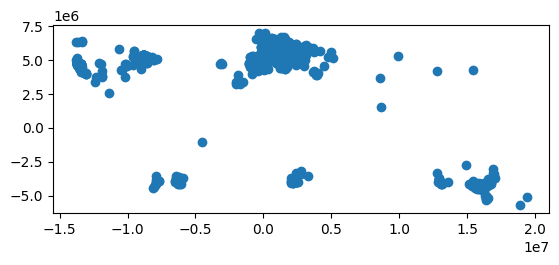

In [72]:
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import unary_union

# Load the shapefile
shapefile_path = 'Resources/Shapefiles/GlobalVineyards.shp'
gdf_shape = gpd.read_file(shapefile_path)

# Ensure the shapefile uses the same coordinate system as the weather data
gdf_shape = gdf_shape.to_crs(epsg=4326)

# Display the first few rows of the GeoDataFrame
print(gdf.head())

# Plot the shapefile
gdf.plot()


In [73]:

# Assuming 'merged_df' contains the weather station data with 'latitude' and 'longitude' columns
stations_df = merged_df.dropna(subset=['latitude', 'longitude'])  # Drop rows with missing coordinates

# Create a GeoDataFrame from the weather station DataFrame
geometry = [Point(xy) for xy in zip(stations_df['longitude'], stations_df['latitude'])]
gdf_stations = gpd.GeoDataFrame(stations_df, geometry=geometry)

# Ensure the GeoDataFrame uses the same coordinate system
gdf_stations.crs = "EPSG:4326"


In [74]:
# Re-project both GeoDataFrames to a projected CRS suitable for distance calculations
projected_crs = "EPSG:3395"  # World Mercator projection
gdf_shape = gdf_shape.to_crs(projected_crs)
gdf_stations = gdf_stations.to_crs(projected_crs)

# Convert distance to meters (100 miles is approximately 160934 meters)
buffer_distance = 160934  # 100 miles in meters

# Create a buffer around the shapefile geometries
shape_buffer = gdf_shape.geometry.buffer(buffer_distance)

# Combine all buffered shapes into a single geometry
combined_shape_buffer = unary_union(shape_buffer)

# Find weather stations within the buffer
stations_within_buffer = gdf_stations[gdf_stations.geometry.within(combined_shape_buffer)]

# Display the results
print(stations_within_buffer)

# Optionally, save the results to a new CSV file
output_file_path = 'Resources/stations_within_100_miles.csv'
stations_within_buffer.to_csv(output_file_path, index=False)
print(f"Stations within 100 miles exported to {output_file_path}")

# Re-project back to geographic CRS for plotting
stations_within_buffer = stations_within_buffer.to_crs(epsg=4326)
shape_buffer_geo = gpd.GeoSeries([combined_shape_buffer], crs=projected_crs).to_crs(epsg=4326)

# Display the results
print(stations_within_buffer)


           station                 date  DP10  DP1X  DT32   DX70  DX90  EMNT  \
16     AG000060390  1995-01-01T00:00:00  40.0   4.0   3.0  239.0  27.0  31.0   
17     AG000060390  1996-01-01T00:00:00  59.0   6.0   2.0  228.0  21.0  29.0   
18     AG000060390  1997-01-01T00:00:00  44.0   5.0   0.0  231.0  20.0  33.0   
19     AG000060390  1998-01-01T00:00:00  47.0   6.0   4.0  220.0  30.0  30.0   
20     AG000060390  2004-01-01T00:00:00  51.0   8.0   NaN    NaN   NaN   NaN   
...            ...                  ...   ...   ...   ...    ...   ...   ...   
30213  UYM00086580  2016-01-01T00:00:00  58.0  13.0   NaN    NaN   NaN   NaN   
30214  UYM00086580  2017-01-01T00:00:00  62.0  18.0   NaN    NaN   NaN   NaN   
30215  UYM00086580  2018-01-01T00:00:00  68.0  15.0   NaN    NaN   NaN   NaN   
30216  UYM00086580  2019-01-01T00:00:00  62.0  16.0   NaN    NaN   NaN   NaN   
30217  UYM00086580  2022-01-01T00:00:00  49.0   7.0   NaN    NaN   NaN   NaN   

       EMXP   EMXT  ...  MXPN   PRCP  T

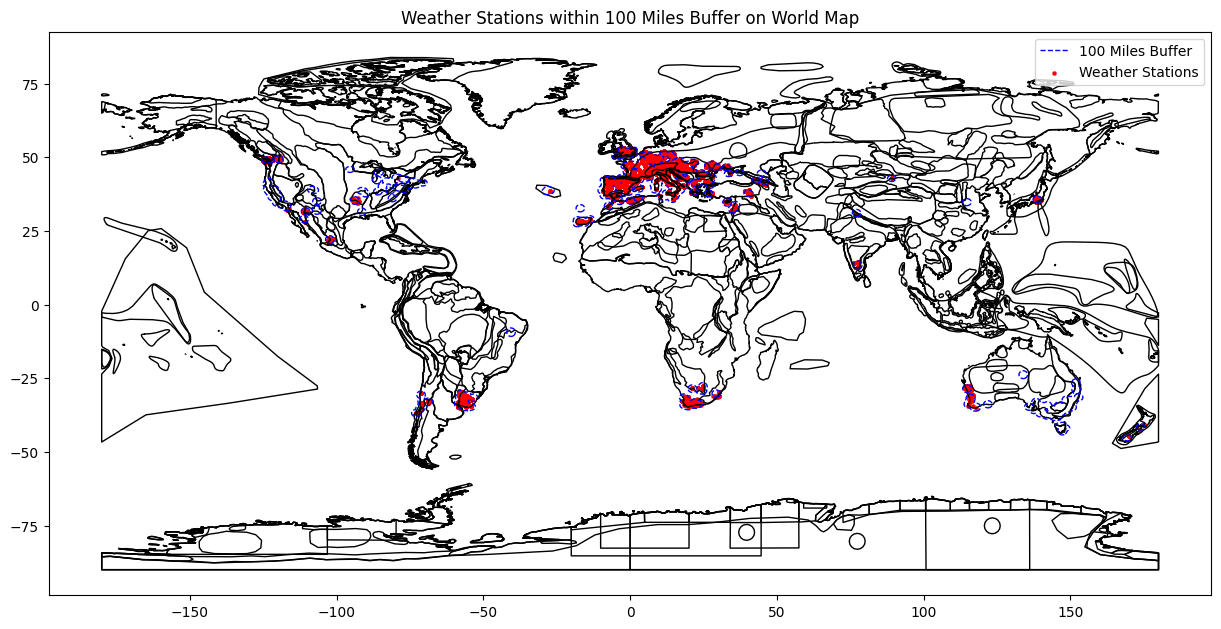

In [75]:
# Load a world map
# Load the world map from Natural Earth dataset
world_shapefile_path = 'Resources/Shapefiles/ne_50m_geography_regions_polys.shp'
world = gpd.read_file(world_shapefile_path)

# Plot the world map, buffer, and stations within the buffer
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax, linewidth=1, color='black')
shape_buffer_geo.boundary.plot(ax=ax, color='blue', linewidth=1, linestyle='--', label='100 Miles Buffer')
stations_within_buffer.plot(ax=ax, color='red', markersize=5, label='Weather Stations')

plt.title('Weather Stations within 100 Miles Buffer on World Map')
plt.legend()
plt.show()


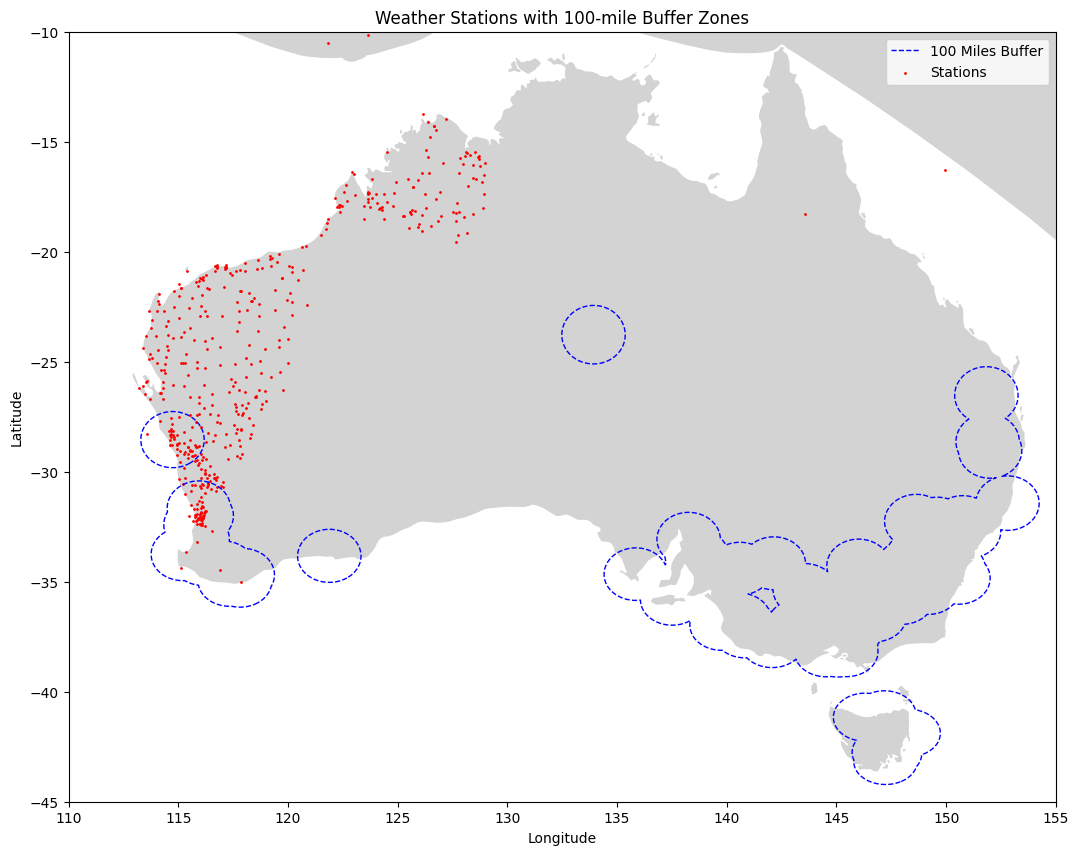

In [85]:
# Remove duplicate points based on latitude and longitude
#merged_df = merged_df.drop_duplicates(subset=['station'])



# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(merged_df['longitude'], merged_df['latitude'])]
gdf = gpd.GeoDataFrame(merged_df, geometry=geometry)

# Set the CRS to WGS84 (EPSG:4326)
gdf.set_crs(epsg=4326, inplace=True)

world_shapefile_path = 'Resources/Shapefiles/ne_50m_geography_regions_polys.shp'
world = gpd.read_file(world_shapefile_path)

# Plot the world map, buffer, and stations within the buffer
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='lightgray')
shape_buffer_geo.boundary.plot(ax=ax, color='blue', linewidth=1, linestyle='--', label='100 Miles Buffer')

# Plot the stations
gdf.plot(ax=ax, color='red', markersize=1, label='Stations')


# Set the limits to zoom in on Australia
ax.set_xlim(110, 155)
ax.set_ylim(-45, -10)

# Add legend and title
plt.legend()
plt.title('Weather Stations with 100-mile Buffer Zones')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [87]:
import pandas as pd

# Load the weather_all_country_codes3.csv file
weather_file_path = 'Resources/weather_all_country_codes3.csv'
weather_df = pd.read_csv(weather_file_path)

# Load the merged_weather_data.csv file
merged_file_path = 'Resources/merged_weather_data.csv'
merged_df = pd.read_csv(merged_file_path)

# Ensure the station identifiers are consistent (e.g., remove 'GHCND:' prefix if necessary)
weather_df['station'] = weather_df['station'].str.replace('GHCND:', '')
merged_df['station'] = merged_df['station'].str.replace('GHCND:', '')

# Calculate the number of unique station IDs in each file
unique_stations_weather = weather_df['station'].nunique()
unique_stations_merged = merged_df['station'].nunique()

print(f"Number of unique stations in weather_all_country_codes3.csv: {unique_stations_weather}")
print(f"Number of unique stations in merged_weather_data.csv: {unique_stations_merged}")


Number of unique stations in weather_all_country_codes3.csv: 6303
Number of unique stations in merged_weather_data.csv: 6303


In [95]:
import pandas as pd

# Load the merged weather station file
merged_file_path = 'Resources/merged_weather_data.csv'
merged_df = pd.read_csv(merged_file_path)

# Load the stations_within_buffer file
stations_within_buffer_file_path = 'Resources/stations_within_100_miles.csv'  # Update this path
stations_within_buffer = pd.read_csv(stations_within_buffer_file_path)

# Load the country codes file
country_codes_file_path = 'Resources/ghcnd-countries.csv'  # Update this path
country_codes_df = pd.read_csv(country_codes_file_path)

# Extract unique country codes
unique_country_codes_merged = set(merged_df['country'].unique())
unique_country_codes_buffer = set(stations_within_buffer['country'].unique())

# Find country codes in merged_df but not in stations_within_buffer
missing_country_codes = unique_country_codes_merged - unique_country_codes_buffer

# Create a dictionary to map country codes to country names
country_code_to_name = dict(zip(country_codes_df['Code'], country_codes_df['Country']))

# Get the country names for the missing country codes
missing_countries = {code: country_code_to_name.get(code, 'Unknown') for code in missing_country_codes}

# Display the results
missing_countries_df = pd.DataFrame(list(missing_countries.items()), columns=['Country Code', 'Country Name'])
print("Country codes and names in merged_df but not in stations_within_buffer:")
print(missing_countries_df)


Country codes and names in merged_df but not in stations_within_buffer:
Empty DataFrame
Columns: [Country Code, Country Name]
Index: []


In [96]:
country_code_to_name
merged_df


,station,date,DP10,DP1X,DT32,DX70,DX90,EMNT,EMXP,EMXT,...,MNPN,MXPN,PRCP,TAVG,TMAX,country,latitude,longitude,elevation,location
0,AE000041196,2012-01-01T00:00:00,NaN,NaN,NaN,346.0,226.0,NaN,NaN,121.0,...,NaN,NaN,NaN,NaN,96.0,GH,25.333,55.517,34.0,SHARJAH INTER. AIRP GSN 41196
1,AE000041196,2023-01-01T00:00:00,8.0,1.0,NaN,NaN,NaN,NaN,1.06,NaN,...,NaN,NaN,3.42,NaN,NaN,GH,25.333,55.517,34.0,SHARJAH INTER. AIRP GSN 41196
2,AEM00041194,2004-01-01T00:00:00,4.0,0.0,NaN,NaN,NaN,NaN,0.90,NaN,...,NaN,NaN,2.31,NaN,NaN,GH,25.255,55.364,10.4,DUBAI INTL 41194
3,AEM00041194,2006-01-01T00:00:00,7.0,1.0,NaN,NaN,NaN,NaN,1.77,NaN,...,NaN,NaN,4.08,NaN,NaN,GH,25.255,55.364,10.4,DUBAI INTL 41194
4,AEM00041194,2010-01-01T00:00:00,5.0,1.0,NaN,NaN,NaN,NaN,3.15,NaN,...,NaN,NaN,4.83,NaN,NaN,GH,25.255,55.364,10.4,DUBAI INTL 41194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31219,WA010101860,2003-01-01T00:00:00,35.0,0.0,0.0,348.0,117.0,38.0,0.87,100.0,...,NaN,NaN,12.60,72.3,85.5,GH,-19.600,18.117,1400.0,GROOTFONTEIN GSN 68014
31220,WA010101860,2022-01-01T00:00:00,NaN,NaN,NaN,348.0,126.0,NaN,NaN,99.0,...,NaN,NaN,NaN,NaN,86.5,GH,-19.600,18.117,1400.0,GROOTFONTEIN GSN 68014
31221,WA012084750,1998-01-01T00:00:00,NaN,NaN,NaN,340.0,210.0,NaN,NaN,103.0,...,NaN,NaN,NaN,NaN,90.7,GH,-17.917,19.767,1100.0,RUNDU 68018
31222,WA012084750,1999-01-01T00:00:00,NaN,NaN,NaN,343.0,132.0,NaN,NaN,102.0,...,NaN,NaN,NaN,NaN,88.3,GH,-17.917,19.767,1100.0,RUNDU 68018
